In [ ]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.4 MB/s eta 0:00:00


In [ ]:
#import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm

from matplotlib import pyplot

from pmdarima.model_selection import train_test_split

from scipy.fftpack import fft,fftshift
from scipy import signal
from scipy.signal import stft
from scipy.signal import savgol_filter

from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from pandas import read_csv

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from google.colab import drive

In [ ]:
#Verbindung mit Google Drive herstellen
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Daten aus Excel Sheet in Dataframe laden
xls = pd.ExcelFile('//content/drive/MyDrive/Testdaten.xlsx')
dataframes = [pd.read_excel(xls, f'Test{i}') for i in range(1, 8)]

final_arrays = [df['Hammer P'] for df in dataframes]
df_num=7

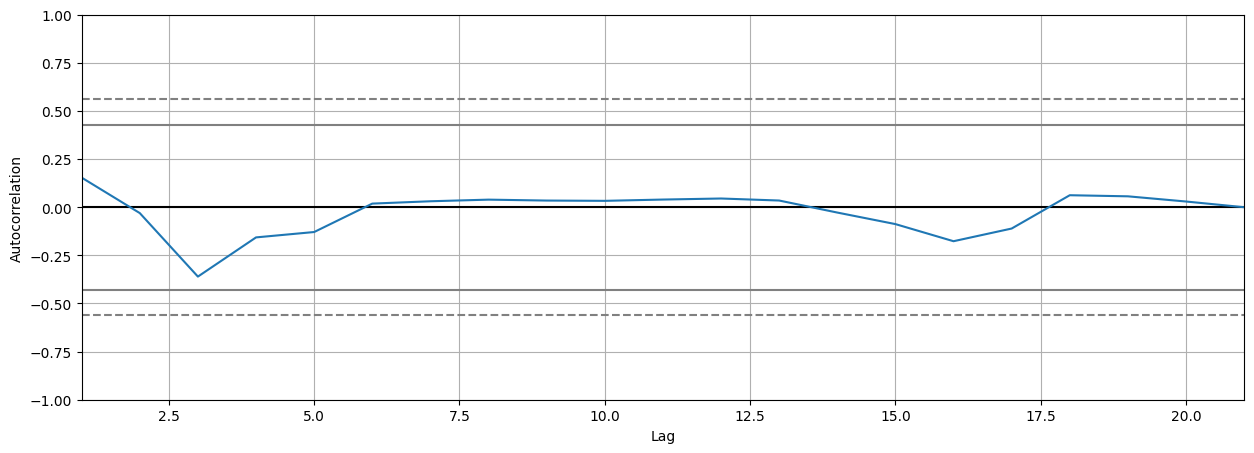

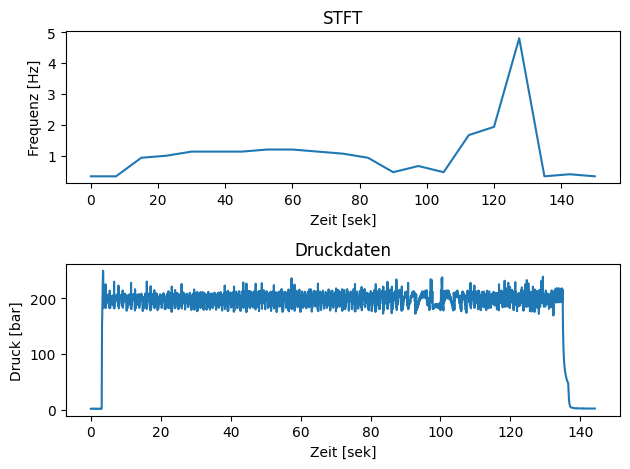

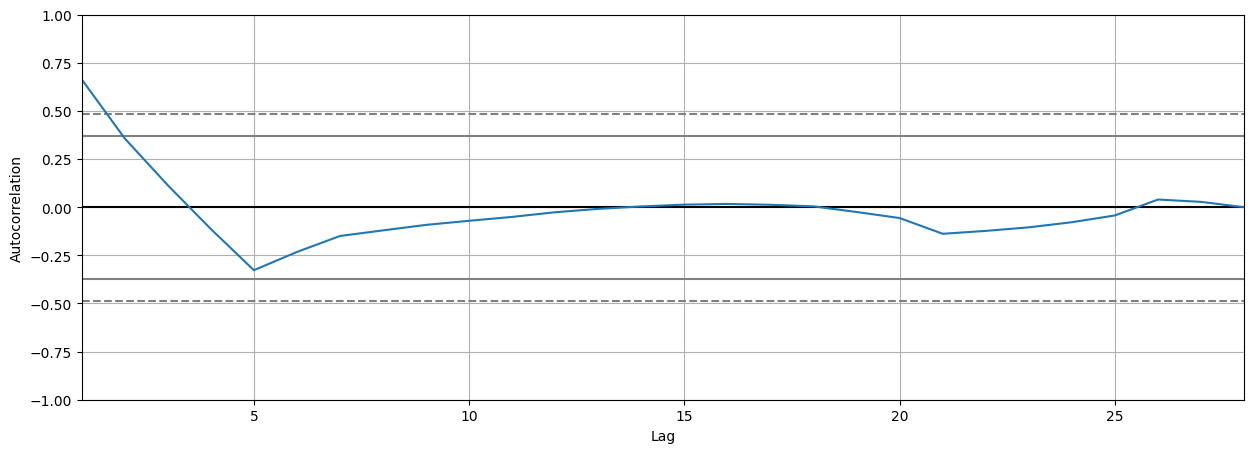

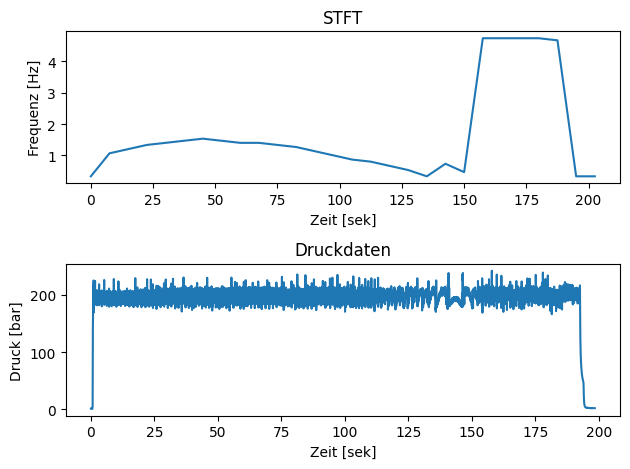

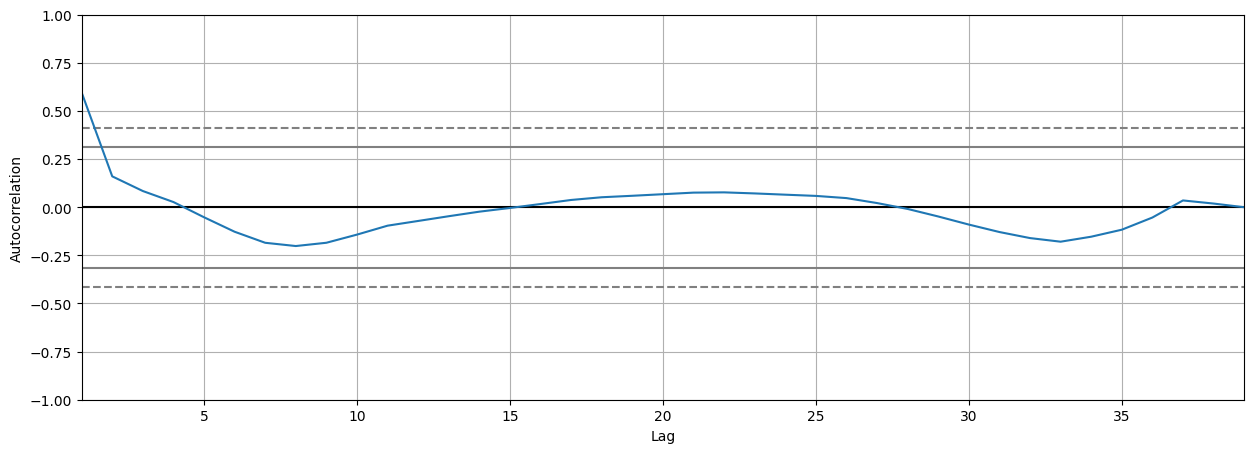

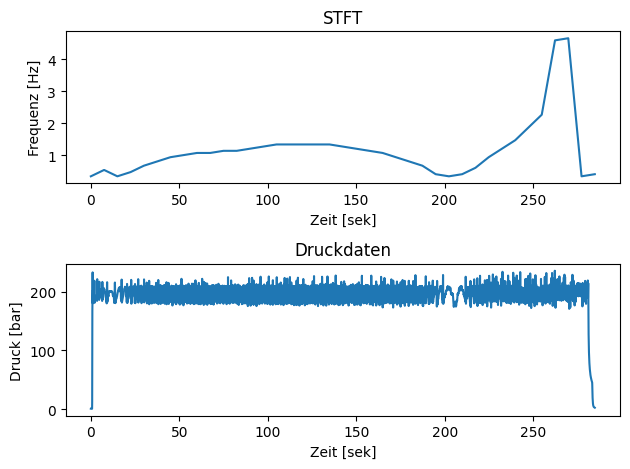

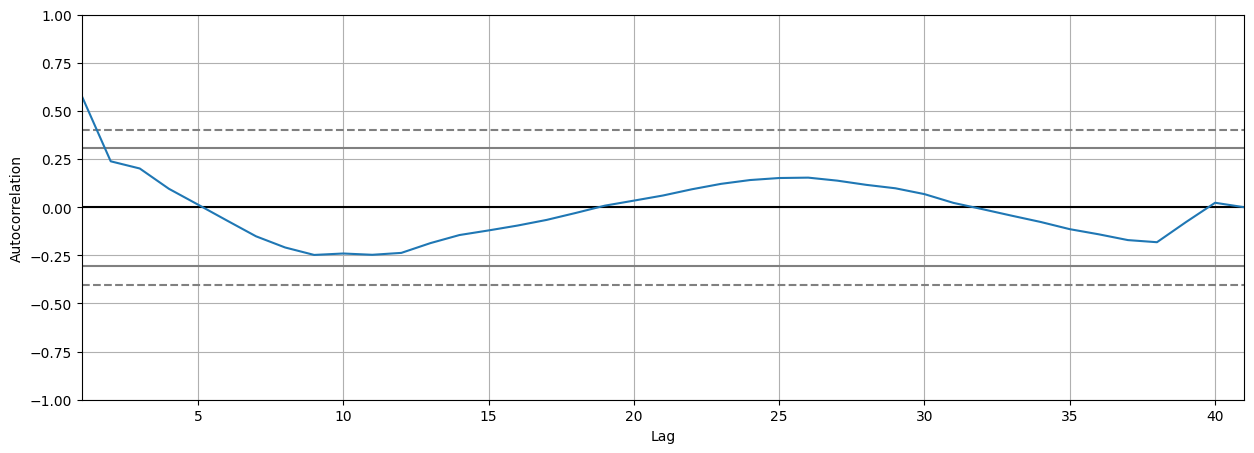

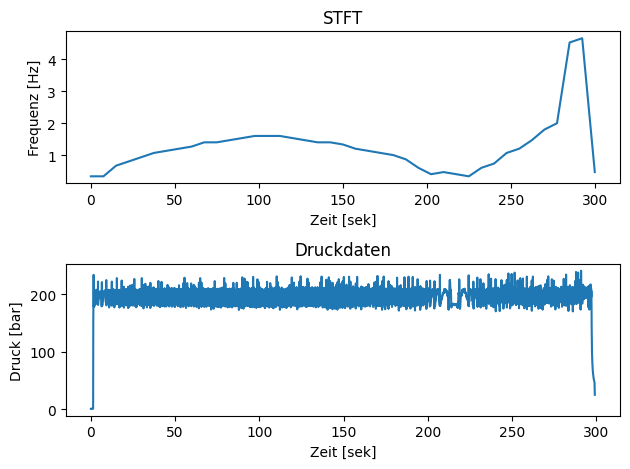

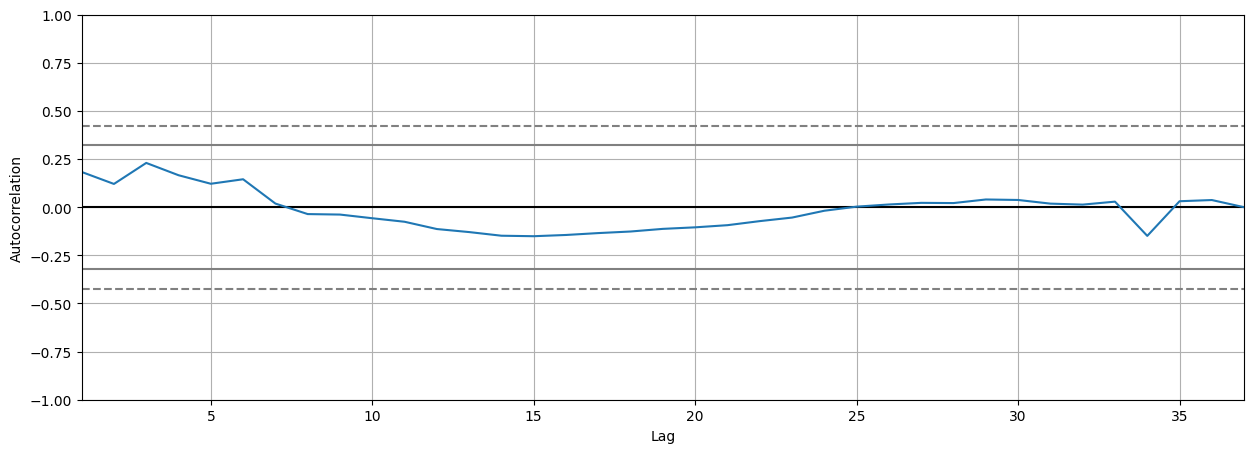

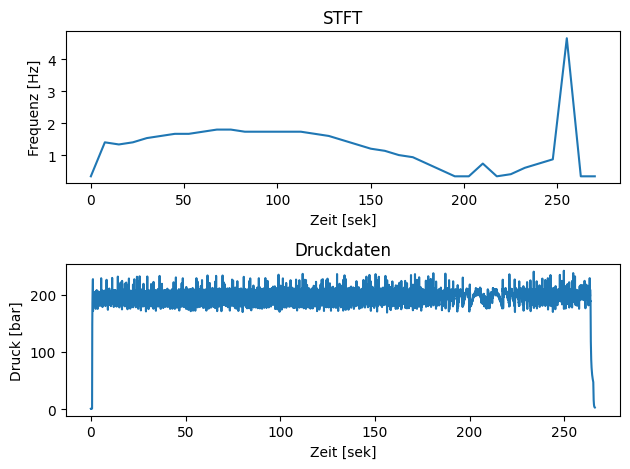

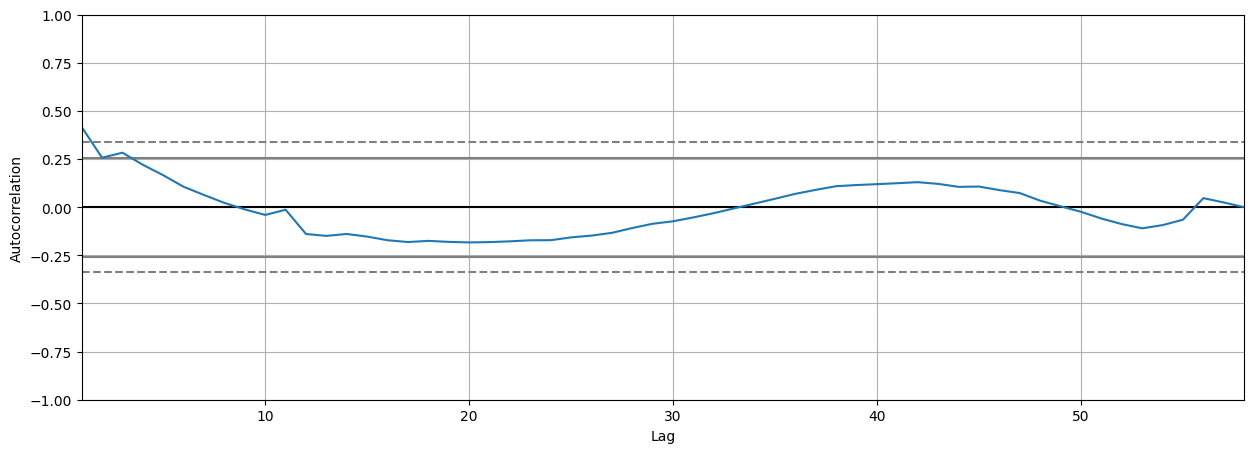

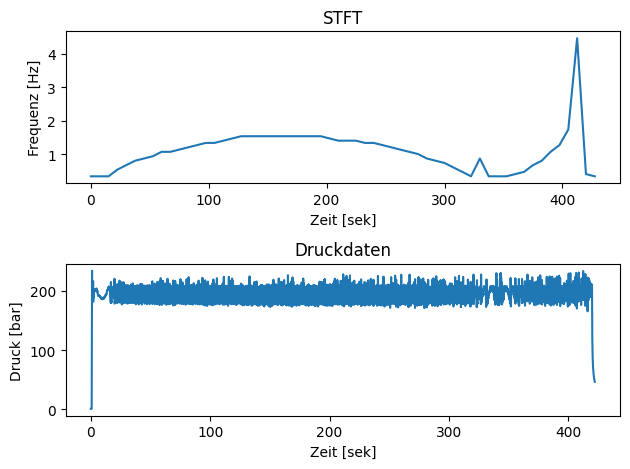

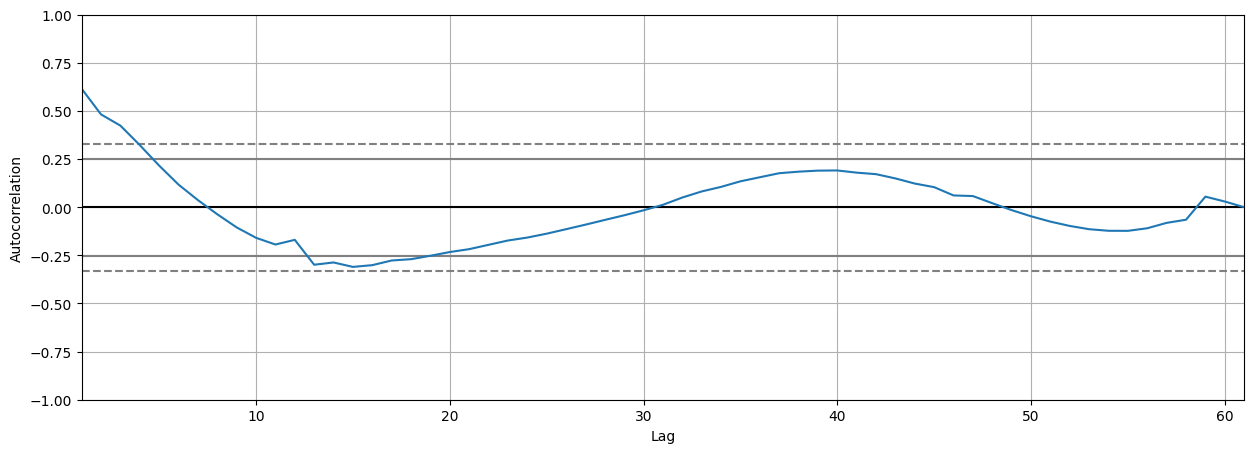

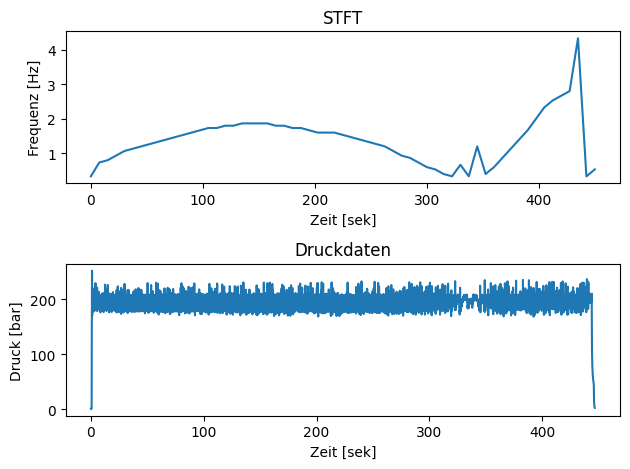

In [ ]:
#STFT durchführen, Ergebnis filtern und dominante Frequenzen extrahieren
dominant_freqs_all = []
t_all = []
for i in range(df_num):
  plt.subplots(1,1, sharex=True, figsize=(15,5))
  f,t,Zxx = signal.stft(final_arrays[i],fs=20, nperseg=300, noverlap=150) #STFT erstellen
  threshold = 0.3
  Zxx[f < threshold, :] = 0 #Nur Frequenzen über Threshhold einbeziehen
  dominant_freqs = f[np.argmax(np.abs(Zxx), axis=0)]
  autocorrelation_plot(dominant_freqs)
  pyplot.show()
  plt.subplot(211)
  plt.plot(t,dominant_freqs)
  plt.title('STFT')
  plt.ylabel('Frequenz [Hz]')
  plt.xlabel('Zeit [sek]')

  dauer_in_s = final_arrays[i].size / 20
  zeitpunkte = np.linspace(0, dauer_in_s, final_arrays[i].size, endpoint=False)
  plt.subplot(212)
  plt.plot(zeitpunkte,final_arrays[i])
  plt.title('Druckdaten')
  plt.ylabel('Druck [bar]')
  plt.xlabel('Zeit [sek]')
  plt.tight_layout()
  dominant_freqs_all.append(dominant_freqs.copy())
  t_all.append(t.copy())


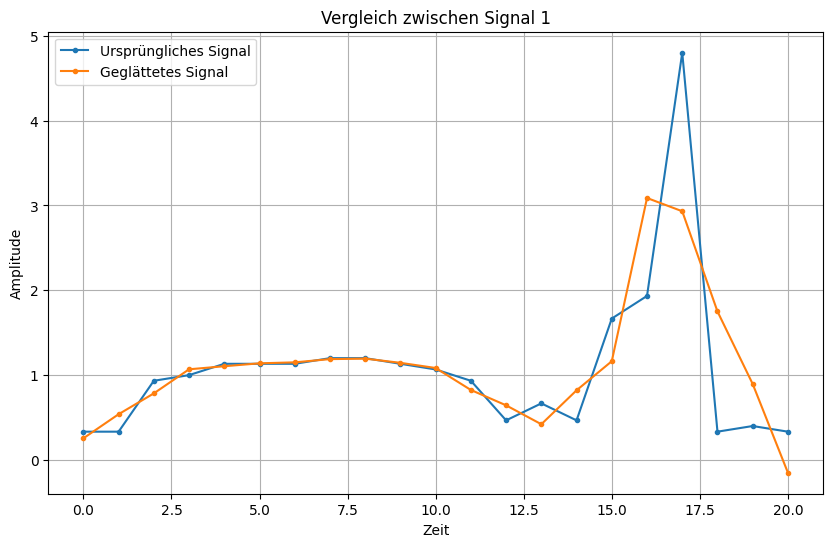

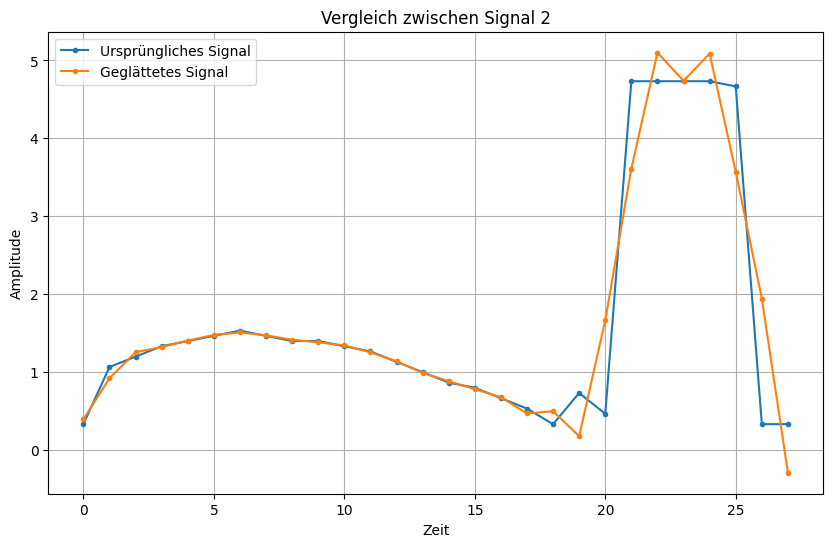

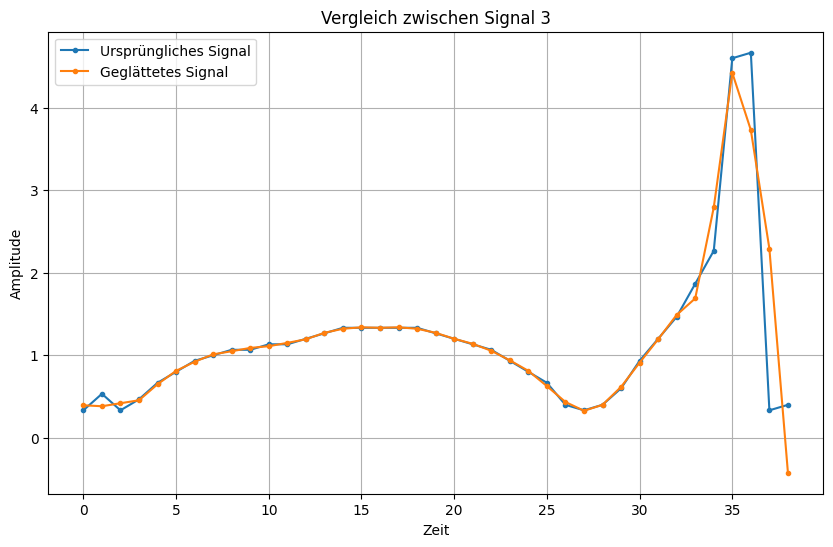

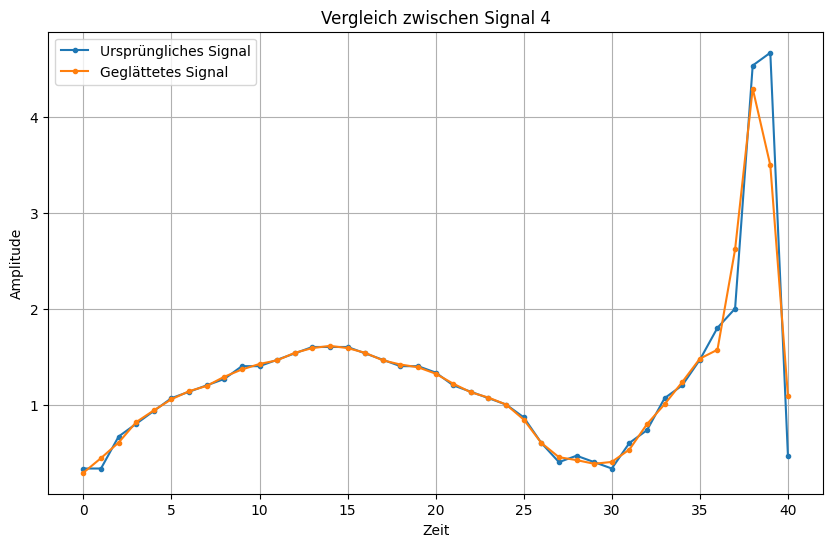

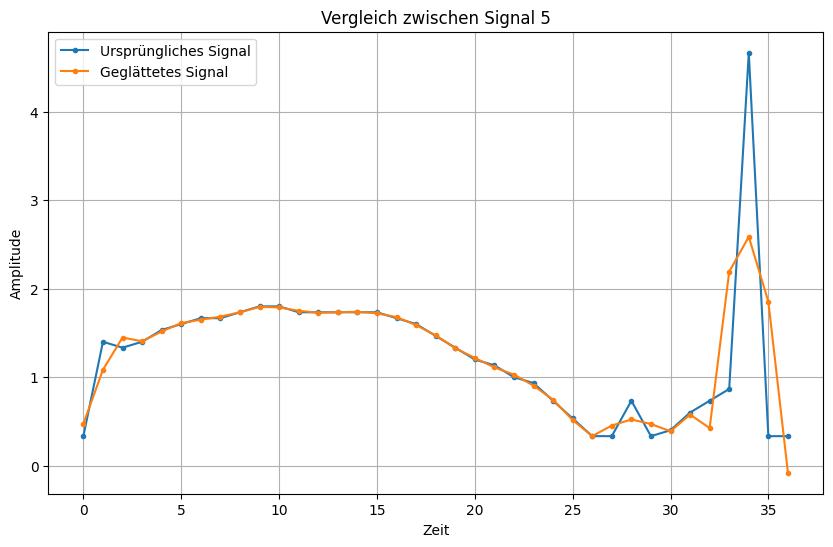

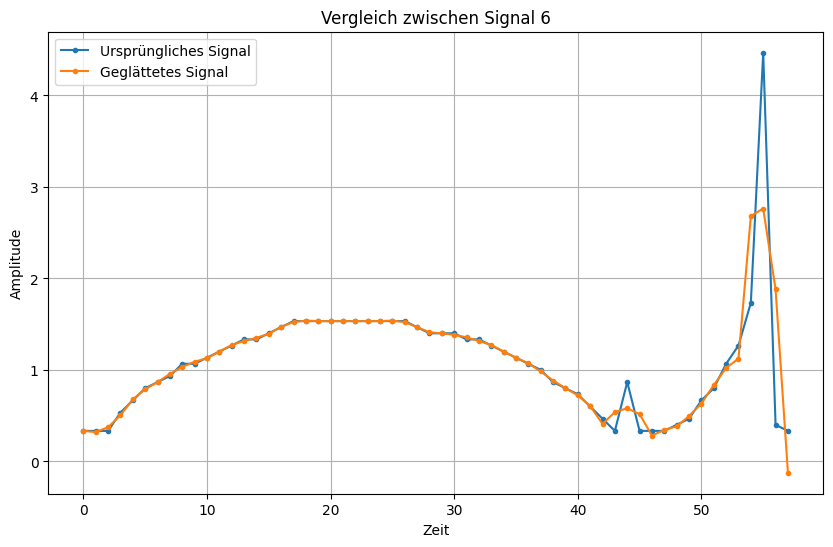

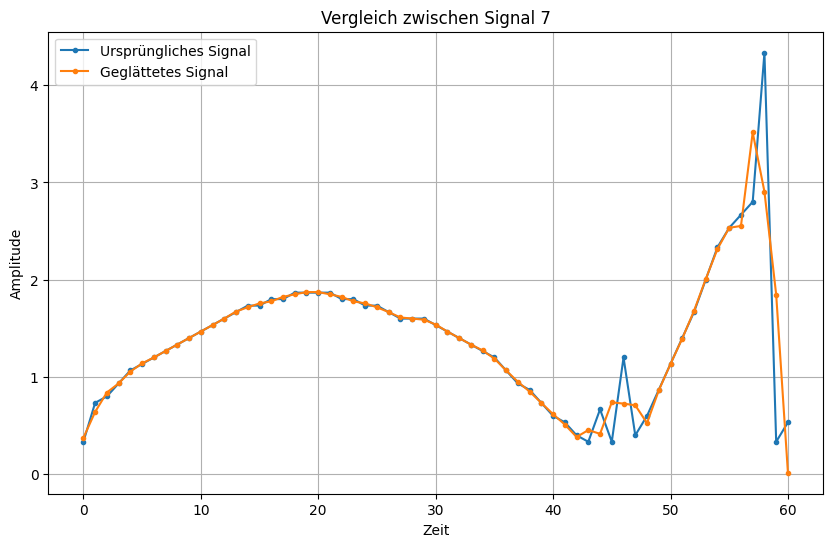

In [ ]:
window_length = 5
polyorder = 2

# Ergebnisse speichern
smoothed_dominant_freqs_all = []

# Schleife über alle dominanten Frequenzen
for i, dominant_freqs in enumerate(dominant_freqs_all):
    # Smoothing durchführen
    smoothed_dominant_freqs = savgol_filter(dominant_freqs, window_length=window_length, polyorder=polyorder)
    smoothed_dominant_freqs_all.append(smoothed_dominant_freqs)

    # Plot für die geglättete Frequenz im Vergleich zum ursprünglichen Wert
    plt.figure(figsize=(10, 6))
    plt.plot(dominant_freqs, label='Ursprüngliches Signal', linestyle='-', marker='o', markersize=3)
    plt.plot(smoothed_dominant_freqs, label='Geglättetes Signal', linestyle='-', marker='o', markersize=3)
    plt.xlabel('Zeit')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.title(f'Vergleich zwischen Signal {i + 1}')
    plt.grid(True)
    plt.show()

RMSE: 0.11330817195041315


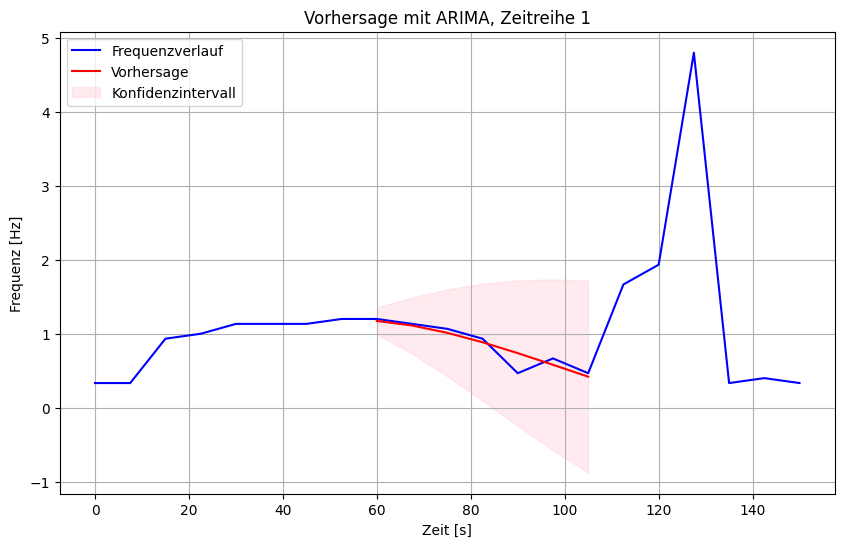

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                    8
Model:               SARIMAX(2, 0, 0)   Log Likelihood                   4.702
Date:                Fri, 03 Nov 2023   AIC                             -3.404
Time:                        08:50:54   BIC                             -3.166
Sample:                             0   HQIC                            -5.012
                                  - 8                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8278      0.154     11.860      0.000       1.526       2.130
ar.L2         -0.8687      0.212     -4.101      0.000      -1.284      -0.454
sigma2         0.0086      0.007      1.169      0.2

In [ ]:
first_time_series = dominant_freqs_all[0]

prediction_start=8 #start der Vorhersage
n_periods = 7 #Dauer der Vorhersage
prediciton_end=prediction_start+n_periods #Ende der Vorhersage
# Smoothing-Parameter
window_length = 5
polyorder = 2

# Glättung der ersten Zeitreihe
smoothed_time_series = savgol_filter(first_time_series, window_length=window_length, polyorder=polyorder)

# Training-Daten auswählen
y = smoothed_time_series[:prediction_start]

# Modell fitten
arima_model = pm.auto_arima(y, seasonal=False, m=1)

# Vorhersage treffen
forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True)

# Zeitpunkte für die Vorhersage
x1 = t_all[0][len(y): len(y) + len(forecast)]
# Plot der ursprünglichen Daten und der Vorhersage
plt.figure(figsize=(10, 6))
plt.plot(t_all[0], first_time_series, color='blue', label='Frequenzverlauf')
plt.plot(x1, forecast, c='red', label='Vorhersage')
plt.fill_between(x1, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Konfidenzintervall')
plt.xlabel('Zeit [s]')
plt.ylabel('Frequenz [Hz]')
plt.legend()
plt.title('Vorhersage mit ARIMA, Zeitreihe 1')
plt.grid(True)

# RMSE berechnen
actual_values = first_time_series[prediction_start:prediciton_end]  # Die tatsächlichen Werte für die Vorhersage-Zeiträume
rmse = sqrt(mean_squared_error(actual_values, forecast))
print(f'RMSE: {rmse}')

plt.show()
print(arima_model.summary())

RMSE: 0.11330817195041315


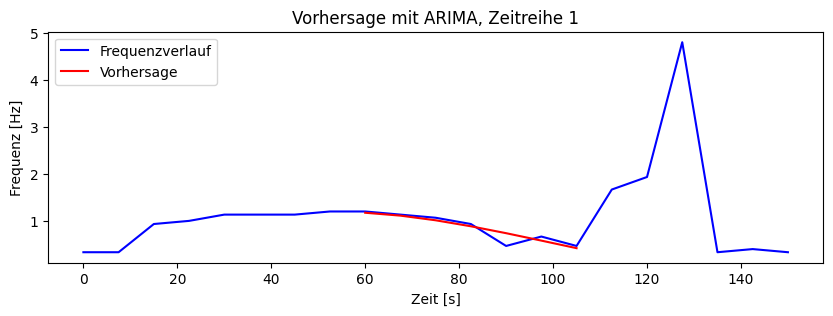

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                    8
Model:               SARIMAX(2, 0, 0)   Log Likelihood                   4.702
Date:                Fri, 10 Nov 2023   AIC                             -3.404
Time:                        10:22:11   BIC                             -3.166
Sample:                             0   HQIC                            -5.012
                                  - 8                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8278      0.154     11.860      0.000       1.526       2.130
ar.L2         -0.8687      0.212     -4.101      0.000      -1.284      -0.454
sigma2         0.0086      0.007      1.169      0.2

In [ ]:
zeitreihe=0 # Hier Zeitreihe eintragen, bei 0 anfangend
first_time_series = dominant_freqs_all[zeitreihe]

prediction_start=8 #start der Vorhersage festlegen
n_periods = 7 #Dauer der Vorhersage festlegen
prediciton_end=prediction_start+n_periods #Ende der Vorhersage
# Smoothing-Parameter festlegen
window_length = 5
polyorder = 2

# Glättung der ersten Zeitreihe
smoothed_time_series = savgol_filter(first_time_series, window_length=window_length, polyorder=polyorder)

# Training-Daten auswählen
y = smoothed_time_series[:prediction_start]

# Modell fitten
arima_model = pm.auto_arima(y, seasonal=False, m=1)

# Vorhersage treffen
forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True)

# Zeitpunkte für die Vorhersage
x1 = t_all[0][len(y): len(y) + len(forecast)]
# Plot der ursprünglichen Daten und der Vorhersage
plt.figure(figsize=(10, 3))
plt.plot(t_all[zeitreihe], first_time_series, color='blue', label='Frequenzverlauf')
plt.plot(x1, forecast, c='red', label='Vorhersage')
plt.xlabel('Zeit [s]')
plt.ylabel('Frequenz [Hz]')
plt.legend()
plt.title(f'Vorhersage mit ARIMA, Zeitreihe {zeitreihe+1}')


# RMSE berechnen
actual_values = first_time_series[prediction_start:prediciton_end]  # Die tatsächlichen Werte für die Vorhersage-Zeiträume
rmse = sqrt(mean_squared_error(actual_values, forecast))
print(f'RMSE: {rmse}')

plt.show()
print(arima_model.summary())

RMSE: 0.24909526762161685


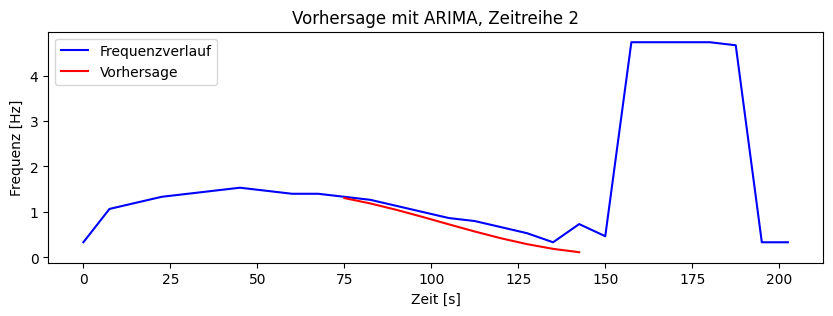

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   10
Model:               SARIMAX(2, 0, 0)   Log Likelihood                  16.414
Date:                Fri, 10 Nov 2023   AIC                            -24.829
Time:                        10:23:38   BIC                            -23.618
Sample:                             0   HQIC                           -26.156
                                 - 10                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0377      0.097      0.390      0.697      -0.152       0.227
ar.L1          1.9234      0.071     27.073      0.000       1.784       2.063
ar.L2         -0.9767      0.027    -36.081      0.0

In [ ]:
first_time_series = dominant_freqs_all[1]

prediction_start=10 #start der Vorhersage
n_periods = 10 #Dauer der Vorhersage
prediciton_end=prediction_start+n_periods #Ende der Vorhersage
# Smoothing-Parameter
window_length = 15
polyorder = 2

# Glättung der ersten Zeitreihe
smoothed_time_series = savgol_filter(first_time_series, window_length=window_length, polyorder=polyorder)

# Training-Daten auswählen
y = smoothed_time_series[:prediction_start]

# Modell fitten
arima_model = pm.auto_arima(y, seasonal=False, m=1)

# Vorhersage treffen
forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True)

#x-Achse anpassen
x1 = t_all[1][len(y): len(y) + len(forecast)]
# Plot der ursprünglichen Daten und der Vorhersage
plt.figure(figsize=(10, 3))
plt.plot(t_all[1], first_time_series, color='blue', label='Frequenzverlauf')
plt.plot(x1, forecast, c='red', label='Vorhersage')
plt.xlabel('Zeit [s]')
plt.ylabel('Frequenz [Hz]')
plt.legend()
plt.title('Vorhersage mit ARIMA, Zeitreihe 2')

# RMSE berechnen
actual_values = first_time_series[prediction_start:prediciton_end]  # Die tatsächlichen Werte für die Vorhersage-Zeiträume
rmse = sqrt(mean_squared_error(actual_values, forecast))
print(f'RMSE: {rmse}')

plt.show()
print(arima_model.summary())

RMSE: 0.24909526762161685


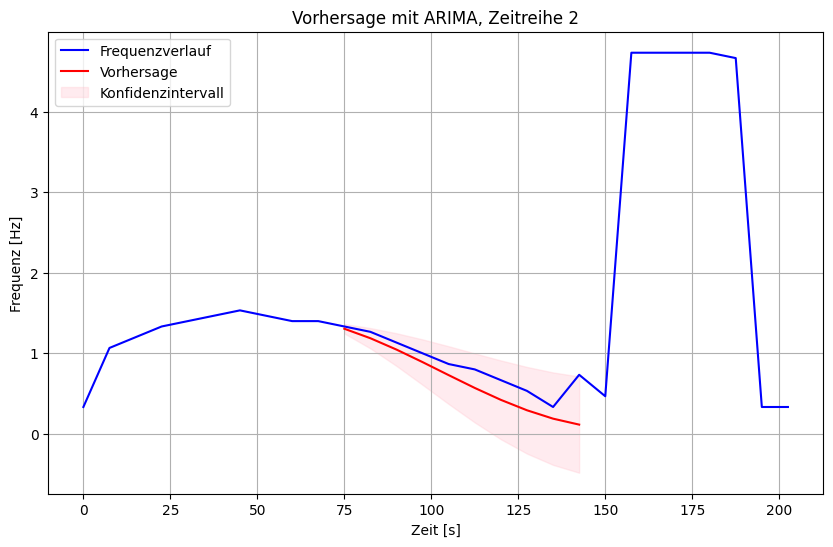

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   10
Model:               SARIMAX(2, 0, 0)   Log Likelihood                  16.414
Date:                Fri, 10 Nov 2023   AIC                            -24.829
Time:                        10:24:18   BIC                            -23.618
Sample:                             0   HQIC                           -26.156
                                 - 10                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0377      0.097      0.390      0.697      -0.152       0.227
ar.L1          1.9234      0.071     27.073      0.000       1.784       2.063
ar.L2         -0.9767      0.027    -36.081      0.0

In [ ]:
first_time_series = dominant_freqs_all[1]

prediction_start=10 #start der Vorhersage
n_periods = 10 #Dauer der Vorhersage
prediciton_end=prediction_start+n_periods #Ende der Vorhersage
# Smoothing-Parameter
window_length = 15
polyorder = 2

# Glättung der ersten Zeitreihe
smoothed_time_series = savgol_filter(first_time_series, window_length=window_length, polyorder=polyorder)

# Training-Daten auswählen
y = smoothed_time_series[:prediction_start]

# Modell fitten
arima_model = pm.auto_arima(y, seasonal=False, m=1)

# Vorhersage treffen
forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True)

#x-Achse anpassen
x1 = t_all[1][len(y): len(y) + len(forecast)]
# Plot der ursprünglichen Daten und der Vorhersage
plt.figure(figsize=(10, 6))
plt.plot(t_all[1], first_time_series, color='blue', label='Frequenzverlauf')
plt.plot(x1, forecast, c='red', label='Vorhersage')
plt.fill_between(x1, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Konfidenzintervall')
plt.xlabel('Zeit [s]')
plt.ylabel('Frequenz [Hz]')
plt.legend()
plt.title('Vorhersage mit ARIMA, Zeitreihe 2')
plt.grid(True)

# RMSE berechnen
actual_values = first_time_series[prediction_start:prediciton_end]  # Die tatsächlichen Werte für die Vorhersage-Zeiträume
rmse = sqrt(mean_squared_error(actual_values, forecast))
print(f'RMSE: {rmse}')

plt.show()
print(arima_model.summary())

RMSE: 0.16535052581456736


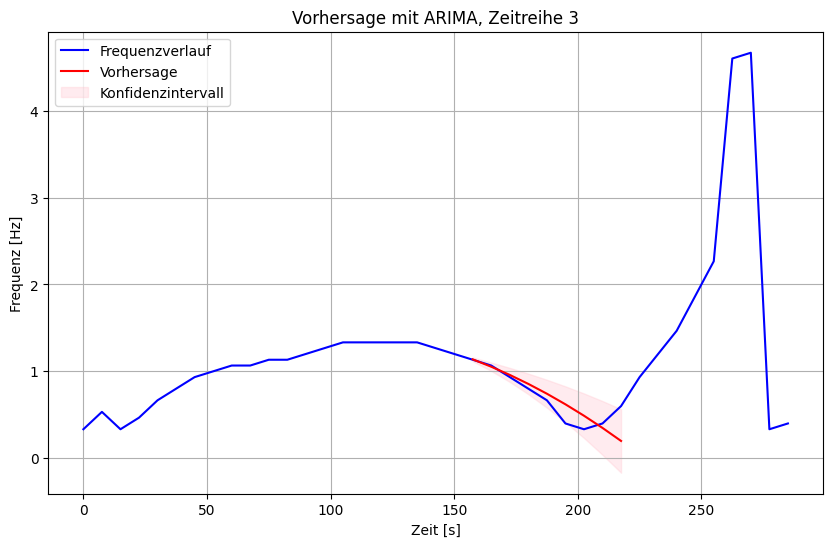

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   21
Model:               SARIMAX(0, 2, 0)   Log Likelihood                  58.641
Date:                Fri, 03 Nov 2023   AIC                           -113.283
Time:                        08:50:46   BIC                           -111.394
Sample:                             0   HQIC                          -112.963
                                 - 21                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0093      0.003     -3.105      0.002      -0.015      -0.003
sigma2         0.0001   3.81e-05      3.205      0.001    4.74e-05       0.000
Ljung-Box (L1) (Q):                   0.06   Jarque-

In [ ]:
first_time_series = dominant_freqs_all[2]

prediction_start=21 #start der Vorhersage
n_periods = 9 #Dauer der Vorhersage
prediciton_end=prediction_start+n_periods #Ende der Vorhersage
# Smoothing-Parameter
window_length = 15
polyorder = 2

# Glättung der ersten Zeitreihe
smoothed_time_series = savgol_filter(first_time_series, window_length=window_length, polyorder=polyorder)

# Training-Daten auswählen
y = smoothed_time_series[:prediction_start]

# Modell fitten
arima_model = pm.auto_arima(y, seasonal=False, m=1)

# Vorhersage treffen
forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True)

x1 = t_all[2][len(y): len(y) + len(forecast)]
# Plot der ursprünglichen Daten und der Vorhersage
plt.figure(figsize=(10, 6))
plt.plot(t_all[2], first_time_series, color='blue', label='Frequenzverlauf')
plt.plot(x1, forecast, c='red', label='Vorhersage')
plt.fill_between(x1, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Konfidenzintervall')
plt.xlabel('Zeit [s]')
plt.ylabel('Frequenz [Hz]')
plt.legend()
plt.title('Vorhersage mit ARIMA, Zeitreihe 3')
plt.grid(True)

# RMSE berechnen
actual_values = first_time_series[prediction_start:prediciton_end]  # Die tatsächlichen Werte für die Vorhersage-Zeiträume
rmse = sqrt(mean_squared_error(actual_values, forecast))
print(f'RMSE: {rmse}')

plt.show()
print(arima_model.summary())

RMSE: 0.16535052581456736


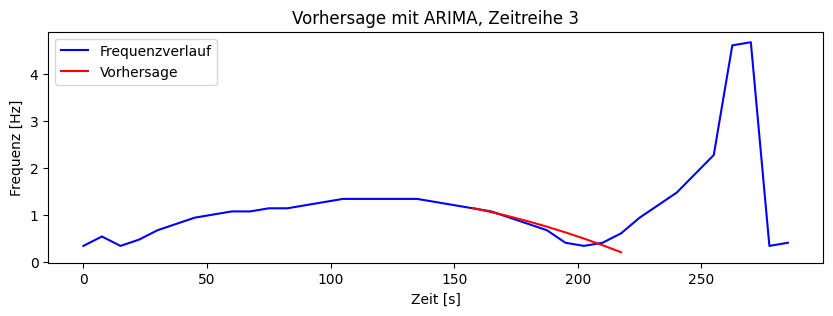

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   21
Model:               SARIMAX(0, 2, 0)   Log Likelihood                  58.641
Date:                Fri, 10 Nov 2023   AIC                           -113.283
Time:                        10:25:05   BIC                           -111.394
Sample:                             0   HQIC                          -112.963
                                 - 21                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0093      0.003     -3.105      0.002      -0.015      -0.003
sigma2         0.0001   3.81e-05      3.205      0.001    4.74e-05       0.000
Ljung-Box (L1) (Q):                   0.06   Jarque-

In [ ]:
first_time_series = dominant_freqs_all[2]

prediction_start=21 #start der Vorhersage
n_periods = 9 #Dauer der Vorhersage
prediciton_end=prediction_start+n_periods #Ende der Vorhersage
# Smoothing-Parameter
window_length = 15
polyorder = 2

# Glättung der ersten Zeitreihe
smoothed_time_series = savgol_filter(first_time_series, window_length=window_length, polyorder=polyorder)

# Training-Daten auswählen
y = smoothed_time_series[:prediction_start]

# Modell fitten
arima_model = pm.auto_arima(y, seasonal=False, m=1)

# Vorhersage treffen
forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True)

x1 = t_all[2][len(y): len(y) + len(forecast)]
# Plot der ursprünglichen Daten und der Vorhersage
plt.figure(figsize=(10, 3))
plt.plot(t_all[2], first_time_series, color='blue', label='Frequenzverlauf')
plt.plot(x1, forecast, c='red', label='Vorhersage')
plt.xlabel('Zeit [s]')
plt.ylabel('Frequenz [Hz]')
plt.legend()
plt.title('Vorhersage mit ARIMA, Zeitreihe 3')

# RMSE berechnen
actual_values = first_time_series[prediction_start:prediciton_end]  # Die tatsächlichen Werte für die Vorhersage-Zeiträume
rmse = sqrt(mean_squared_error(actual_values, forecast))
print(f'RMSE: {rmse}')

plt.show()
print(arima_model.summary())

RMSE: 0.17565532669173822


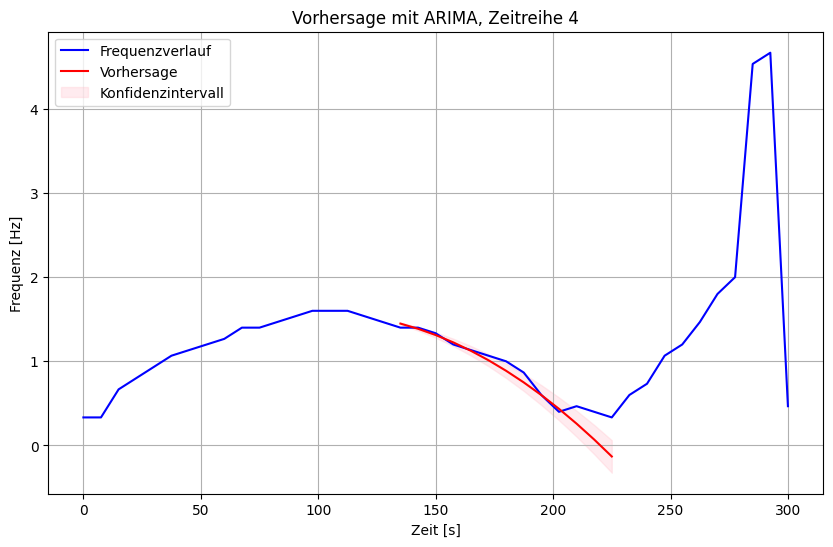

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   18
Model:               SARIMAX(0, 2, 1)   Log Likelihood                  59.180
Date:                Fri, 03 Nov 2023   AIC                           -112.360
Time:                        08:50:44   BIC                           -110.042
Sample:                             0   HQIC                          -112.241
                                 - 18                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0127      0.001    -14.695      0.000      -0.014      -0.011
ma.L1         -0.4741      0.238     -1.996      0.046      -0.940      -0.009
sigma2      3.527e-05   1.55e-05      2.280      0.0

In [ ]:
first_time_series = dominant_freqs_all[3]

prediction_start=18 #start der Vorhersage
n_periods = 13 #Dauer der Vorhersage
prediciton_end=prediction_start+n_periods #Ende der Vorhersage
# Smoothing-Parameter
window_length = 15
polyorder = 2

# Glättung der ersten Zeitreihe
smoothed_time_series = savgol_filter(first_time_series, window_length=window_length, polyorder=polyorder)

# Training-Daten auswählen
y = smoothed_time_series[:prediction_start]

# Modell fitten
arima_model = pm.auto_arima(y, seasonal=False, m=1)

# Vorhersage treffen
forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True)

x1 = t_all[3][len(y): len(y) + len(forecast)]
# Plot der ursprünglichen Daten und der Vorhersage
plt.figure(figsize=(10, 6))
plt.plot(t_all[3], first_time_series, color='blue', label='Frequenzverlauf')
plt.plot(x1, forecast, c='red', label='Vorhersage')
plt.fill_between(x1, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Konfidenzintervall')
plt.xlabel('Zeit [s]')
plt.ylabel('Frequenz [Hz]')
plt.legend()
plt.title('Vorhersage mit ARIMA, Zeitreihe 4')
plt.grid(True)
# RMSE berechnen
actual_values = first_time_series[prediction_start:prediciton_end]  # Die tatsächlichen Werte für die Vorhersage-Zeiträume
rmse = sqrt(mean_squared_error(actual_values, forecast))
print(f'RMSE: {rmse}')

plt.show()
print(arima_model.summary())

RMSE: 0.17565532669173822


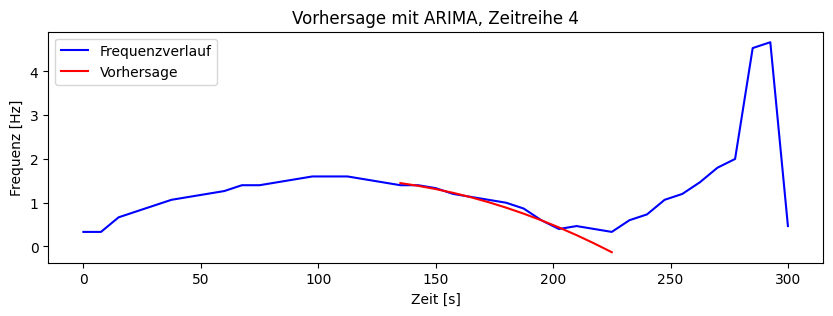

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   18
Model:               SARIMAX(0, 2, 1)   Log Likelihood                  59.180
Date:                Fri, 10 Nov 2023   AIC                           -112.360
Time:                        10:25:52   BIC                           -110.042
Sample:                             0   HQIC                          -112.241
                                 - 18                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0127      0.001    -14.695      0.000      -0.014      -0.011
ma.L1         -0.4741      0.238     -1.996      0.046      -0.940      -0.009
sigma2      3.527e-05   1.55e-05      2.280      0.0

In [ ]:
first_time_series = dominant_freqs_all[3]

prediction_start=18 #start der Vorhersage
n_periods = 13 #Dauer der Vorhersage
prediciton_end=prediction_start+n_periods #Ende der Vorhersage
# Smoothing-Parameter
window_length = 15
polyorder = 2

# Glättung der ersten Zeitreihe
smoothed_time_series = savgol_filter(first_time_series, window_length=window_length, polyorder=polyorder)

# Training-Daten auswählen
y = smoothed_time_series[:prediction_start]

# Modell fitten
arima_model = pm.auto_arima(y, seasonal=False, m=1)

# Vorhersage treffen
forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True)

x1 = t_all[3][len(y): len(y) + len(forecast)]
# Plot der ursprünglichen Daten und der Vorhersage
plt.figure(figsize=(10, 3))
plt.plot(t_all[3], first_time_series, color='blue', label='Frequenzverlauf')
plt.plot(x1, forecast, c='red', label='Vorhersage')
plt.xlabel('Zeit [s]')
plt.ylabel('Frequenz [Hz]')
plt.legend()
plt.title('Vorhersage mit ARIMA, Zeitreihe 4')

# RMSE berechnen
actual_values = first_time_series[prediction_start:prediciton_end]  # Die tatsächlichen Werte für die Vorhersage-Zeiträume
rmse = sqrt(mean_squared_error(actual_values, forecast))
print(f'RMSE: {rmse}')

plt.show()
print(arima_model.summary())

RMSE: 0.27408081064669043


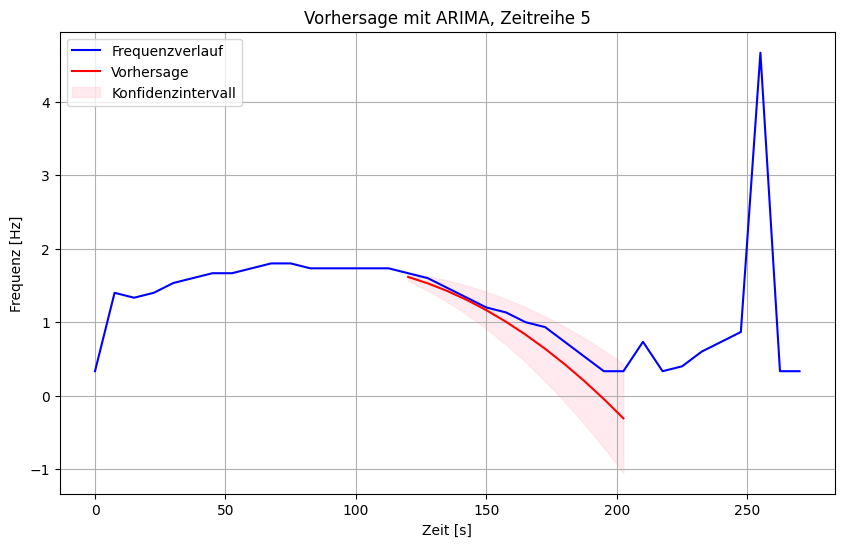

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   16
Model:               SARIMAX(0, 2, 1)   Log Likelihood                  29.831
Date:                Fri, 03 Nov 2023   AIC                            -53.662
Time:                        08:50:41   BIC                            -51.745
Sample:                             0   HQIC                           -53.840
                                 - 16                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0176      0.008     -2.145      0.032      -0.034      -0.002
ma.L1         -0.5449      0.280     -1.947      0.052      -1.094       0.004
sigma2         0.0008      0.000      2.491      0.0

In [ ]:
first_time_series = dominant_freqs_all[4]

prediction_start=16 #start der Vorhersage
n_periods = 12 #Dauer der Vorhersage
prediciton_end=prediction_start+n_periods #Ende der Vorhersage
# Smoothing-Parameter
window_length = 15
polyorder = 2

# Glättung der ersten Zeitreihe
smoothed_time_series = savgol_filter(first_time_series, window_length=window_length, polyorder=polyorder)

# Training-Daten auswählen
y = smoothed_time_series[:prediction_start]

# Modell fitten
arima_model = pm.auto_arima(y, seasonal=False, m=1)

# Vorhersage treffen
forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True)

x1 = t_all[4][len(y): len(y) + len(forecast)]
# Plot der ursprünglichen Daten und der Vorhersage
plt.figure(figsize=(10, 6))
plt.plot(t_all[4], first_time_series, color='blue', label='Frequenzverlauf')
plt.plot(x1, forecast, c='red', label='Vorhersage')
plt.fill_between(x1, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Konfidenzintervall')
plt.xlabel('Zeit [s]')
plt.ylabel('Frequenz [Hz]')
plt.legend()
plt.title('Vorhersage mit ARIMA, Zeitreihe 5')
plt.grid(True)

# RMSE berechnen
actual_values = first_time_series[prediction_start:prediciton_end]  # Die tatsächlichen Werte für die Vorhersage-Zeiträume
rmse = sqrt(mean_squared_error(actual_values, forecast))
print(f'RMSE: {rmse}')

plt.show()
print(arima_model.summary())

RMSE: 0.27408081064669043


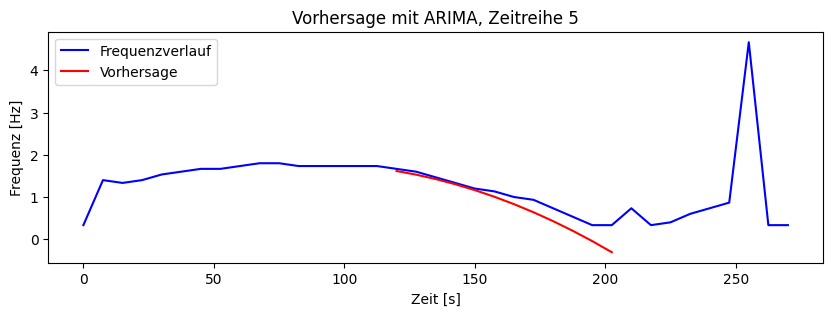

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   16
Model:               SARIMAX(0, 2, 1)   Log Likelihood                  29.831
Date:                Fri, 10 Nov 2023   AIC                            -53.662
Time:                        10:26:32   BIC                            -51.745
Sample:                             0   HQIC                           -53.840
                                 - 16                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0176      0.008     -2.145      0.032      -0.034      -0.002
ma.L1         -0.5449      0.280     -1.947      0.052      -1.094       0.004
sigma2         0.0008      0.000      2.491      0.0

In [ ]:
first_time_series = dominant_freqs_all[4]

prediction_start=16 #start der Vorhersage
n_periods = 12 #Dauer der Vorhersage
prediciton_end=prediction_start+n_periods #Ende der Vorhersage
# Smoothing-Parameter
window_length = 15
polyorder = 2

# Glättung der ersten Zeitreihe
smoothed_time_series = savgol_filter(first_time_series, window_length=window_length, polyorder=polyorder)

# Training-Daten auswählen
y = smoothed_time_series[:prediction_start]

# Modell fitten
arima_model = pm.auto_arima(y, seasonal=False, m=1)

# Vorhersage treffen
forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True)

x1 = t_all[4][len(y): len(y) + len(forecast)]
# Plot der ursprünglichen Daten und der Vorhersage
plt.figure(figsize=(10, 3))
plt.plot(t_all[4], first_time_series, color='blue', label='Frequenzverlauf')
plt.plot(x1, forecast, c='red', label='Vorhersage')
plt.xlabel('Zeit [s]')
plt.ylabel('Frequenz [Hz]')
plt.legend()
plt.title('Vorhersage mit ARIMA, Zeitreihe 5')

# RMSE berechnen
actual_values = first_time_series[prediction_start:prediciton_end]  # Die tatsächlichen Werte für die Vorhersage-Zeiträume
rmse = sqrt(mean_squared_error(actual_values, forecast))
print(f'RMSE: {rmse}')

plt.show()
print(arima_model.summary())

RMSE: 0.3489240417832456


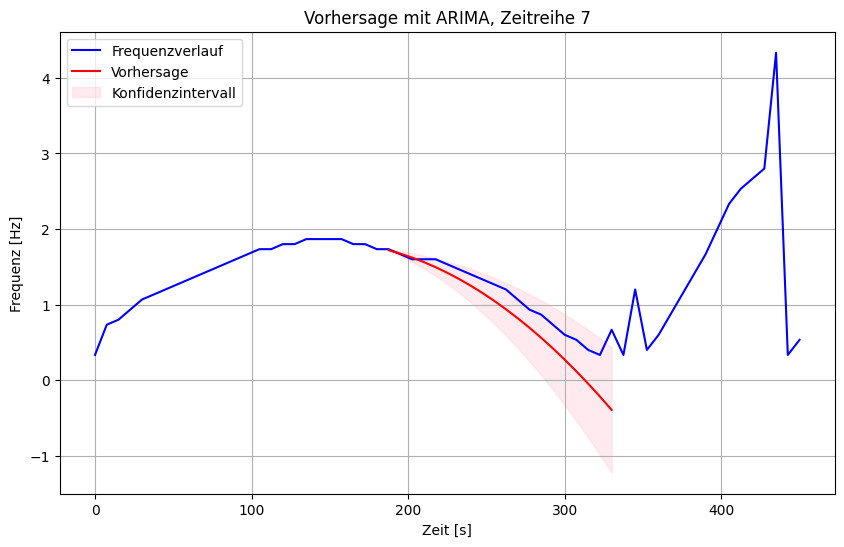

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   25
Model:               SARIMAX(0, 2, 0)   Log Likelihood                  78.664
Date:                Fri, 03 Nov 2023   AIC                           -153.328
Time:                        08:50:36   BIC                           -151.057
Sample:                             0   HQIC                          -152.756
                                 - 25                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0073      0.002     -4.330      0.000      -0.011      -0.004
sigma2      6.262e-05   1.08e-05      5.820      0.000    4.15e-05    8.37e-05
Ljung-Box (L1) (Q):                   2.06   Jarque-

In [ ]:
first_time_series = dominant_freqs_all[6]

prediction_start=25 #start der Vorhersage
n_periods = 20 #Dauer der Vorhersage
prediciton_end=prediction_start+n_periods #Ende der Vorhersage
# Smoothing-Parameter
window_length = 15
polyorder = 2

# Glättung der ersten Zeitreihe
smoothed_time_series = savgol_filter(first_time_series, window_length=window_length, polyorder=polyorder)

# Training-Daten auswählen
y = smoothed_time_series[:prediction_start]

# Modell fitten
arima_model = pm.auto_arima(y, seasonal=False, m=1)

# Vorhersage treffen
forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True)

x1 = t_all[6][len(y): len(y) + len(forecast)]
# Plot der ursprünglichen Daten und der Vorhersage
plt.figure(figsize=(10, 6))
plt.plot(t_all[6], first_time_series, color='blue', label='Frequenzverlauf')
plt.plot(x1, forecast, c='red', label='Vorhersage')
plt.fill_between(x1, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Konfidenzintervall')
plt.xlabel('Zeit [s]')
plt.ylabel('Frequenz [Hz]')
plt.legend()
plt.title('Vorhersage mit ARIMA, Zeitreihe 7')
plt.grid(True)

# RMSE berechnen
actual_values = first_time_series[prediction_start:prediciton_end]  # Die tatsächlichen Werte für die Vorhersage-Zeiträume
rmse = sqrt(mean_squared_error(actual_values, forecast))
print(f'RMSE: {rmse}')

plt.show()
print(arima_model.summary())

RMSE: 0.3489240417832456


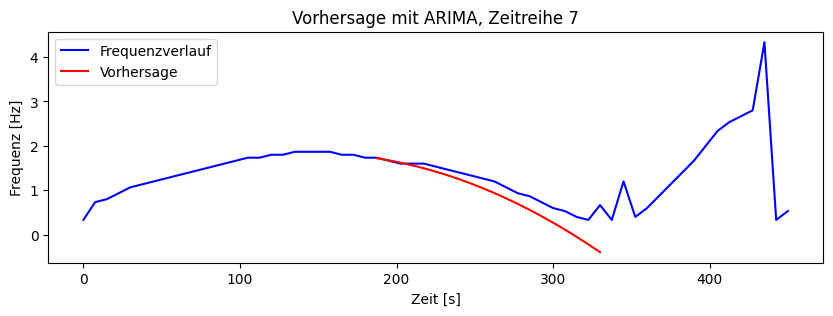

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   25
Model:               SARIMAX(0, 2, 0)   Log Likelihood                  78.664
Date:                Fri, 10 Nov 2023   AIC                           -153.328
Time:                        10:27:03   BIC                           -151.057
Sample:                             0   HQIC                          -152.756
                                 - 25                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0073      0.002     -4.330      0.000      -0.011      -0.004
sigma2      6.262e-05   1.08e-05      5.820      0.000    4.15e-05    8.37e-05
Ljung-Box (L1) (Q):                   2.06   Jarque-

In [ ]:
first_time_series = dominant_freqs_all[6]

prediction_start=25 #start der Vorhersage
n_periods = 20 #Dauer der Vorhersage
prediciton_end=prediction_start+n_periods #Ende der Vorhersage
# Smoothing-Parameter
window_length = 15
polyorder = 2

# Glättung der ersten Zeitreihe
smoothed_time_series = savgol_filter(first_time_series, window_length=window_length, polyorder=polyorder)

# Training-Daten auswählen
y = smoothed_time_series[:prediction_start]

# Modell fitten
arima_model = pm.auto_arima(y, seasonal=False, m=1)

# Vorhersage treffen
forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True)

x1 = t_all[6][len(y): len(y) + len(forecast)]
# Plot der ursprünglichen Daten und der Vorhersage
plt.figure(figsize=(10, 3))
plt.plot(t_all[6], first_time_series, color='blue', label='Frequenzverlauf')
plt.plot(x1, forecast, c='red', label='Vorhersage')
plt.xlabel('Zeit [s]')
plt.ylabel('Frequenz [Hz]')
plt.legend()
plt.title('Vorhersage mit ARIMA, Zeitreihe 7')

# RMSE berechnen
actual_values = first_time_series[prediction_start:prediciton_end]  # Die tatsächlichen Werte für die Vorhersage-Zeiträume
rmse = sqrt(mean_squared_error(actual_values, forecast))
print(f'RMSE: {rmse}')

plt.show()
print(arima_model.summary())

RMSE: 0.13848279431895003


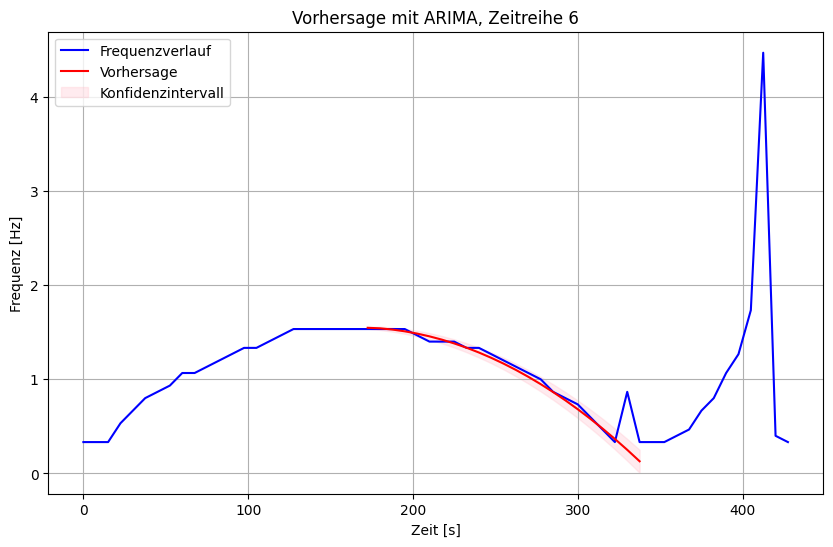

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   23
Model:               SARIMAX(0, 2, 4)   Log Likelihood                  81.297
Date:                Fri, 03 Nov 2023   AIC                           -150.593
Time:                        08:50:31   BIC                           -144.326
Sample:                             0   HQIC                          -149.233
                                 - 23                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0054      0.000    -16.738      0.000      -0.006      -0.005
ma.L1         -0.3712      0.454     -0.818      0.413      -1.260       0.518
ma.L2         -0.8580      0.610     -1.406      0.1

In [ ]:
first_time_series = dominant_freqs_all[5]

prediction_start=23 #start der Vorhersage
n_periods = 23 #Dauer der Vorhersage
prediciton_end=prediction_start+n_periods #Ende der Vorhersage
# Smoothing-Parameter
window_length = 15
polyorder = 2

# Glättung der ersten Zeitreihe
smoothed_time_series = savgol_filter(first_time_series, window_length=window_length, polyorder=polyorder)

# Training-Daten auswählen
y = smoothed_time_series[:prediction_start]

# Modell fitten
arima_model = pm.auto_arima(y, seasonal=False, m=1)

# Vorhersage treffen
forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True)

x1 = t_all[5][len(y): len(y) + len(forecast)]
# Plot der ursprünglichen Daten und der Vorhersage
plt.figure(figsize=(10, 6))
plt.plot(t_all[5], first_time_series, color='blue', label='Frequenzverlauf')
plt.plot(x1, forecast, c='red', label='Vorhersage')
plt.fill_between(x1, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Konfidenzintervall')
plt.xlabel('Zeit [s]')
plt.ylabel('Frequenz [Hz]')
plt.legend()
plt.title('Vorhersage mit ARIMA, Zeitreihe 6')
plt.grid(True)

# RMSE berechnen
actual_values = first_time_series[prediction_start:prediciton_end]  # Die tatsächlichen Werte für die Vorhersage-Zeiträume
rmse = sqrt(mean_squared_error(actual_values, forecast))
print(f'RMSE: {rmse}')

plt.show()
print(arima_model.summary())



RMSE: 0.13848279431895003


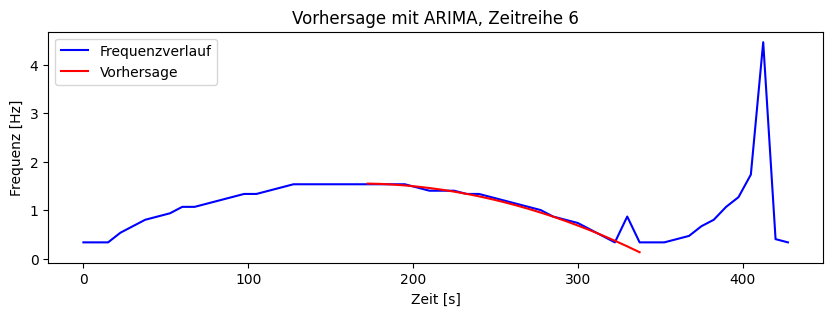

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   23
Model:               SARIMAX(0, 2, 4)   Log Likelihood                  81.297
Date:                Fri, 10 Nov 2023   AIC                           -150.593
Time:                        10:27:46   BIC                           -144.326
Sample:                             0   HQIC                          -149.233
                                 - 23                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0054      0.000    -16.738      0.000      -0.006      -0.005
ma.L1         -0.3712      0.454     -0.818      0.413      -1.260       0.518
ma.L2         -0.8580      0.610     -1.406      0.1

In [ ]:
first_time_series = dominant_freqs_all[5]

prediction_start=23 #start der Vorhersage
n_periods = 23 #Dauer der Vorhersage
prediciton_end=prediction_start+n_periods #Ende der Vorhersage
# Smoothing-Parameter
window_length = 15
polyorder = 2

# Glättung der ersten Zeitreihe
smoothed_time_series = savgol_filter(first_time_series, window_length=window_length, polyorder=polyorder)

# Training-Daten auswählen
y = smoothed_time_series[:prediction_start]

# Modell fitten
arima_model = pm.auto_arima(y, seasonal=False, m=1)

# Vorhersage treffen
forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True)

x1 = t_all[5][len(y): len(y) + len(forecast)]
# Plot der ursprünglichen Daten und der Vorhersage
plt.figure(figsize=(10, 3))
plt.plot(t_all[5], first_time_series, color='blue', label='Frequenzverlauf')
plt.plot(x1, forecast, c='red', label='Vorhersage')
plt.xlabel('Zeit [s]')
plt.ylabel('Frequenz [Hz]')
plt.legend()
plt.title('Vorhersage mit ARIMA, Zeitreihe 6')


# RMSE berechnen
actual_values = first_time_series[prediction_start:prediciton_end]  # Die tatsächlichen Werte für die Vorhersage-Zeiträume
rmse = sqrt(mean_squared_error(actual_values, forecast))
print(f'RMSE: {rmse}')

plt.show()
print(arima_model.summary())



Predicted=1.0592091257238279, Expected=1.2
Predicted=1.174072963633513, Expected=1.2666666666666666
Predicted=1.2495208050601583, Expected=1.3333333333333333
Predicted=1.3405438138221746, Expected=1.4
Predicted=1.3851214167420798, Expected=1.4666666666666666
Predicted=1.5799977204289444, Expected=1.5333333333333332
Predicted=1.6424220133681224, Expected=1.6
Predicted=1.7055503001957277, Expected=1.6666666666666667
Predicted=1.7692300633124005, Expected=1.7333333333333334
Predicted=1.8333333333333335, Expected=1.7333333333333334
Predicted=1.8169106810671924, Expected=1.8
Predicted=1.769216569101043, Expected=1.8
Predicted=1.8169265897868312, Expected=1.8666666666666667
Predicted=1.8466751247470545, Expected=1.8666666666666667
Predicted=1.9611003188258056, Expected=1.8666666666666667
Predicted=1.8858352119761819, Expected=1.8666666666666667
Predicted=1.865576100297873, Expected=1.8
Predicted=1.8022977271700609, Expected=1.8
Predicted=1.7108627390430635, Expected=1.7333333333333334
Predic

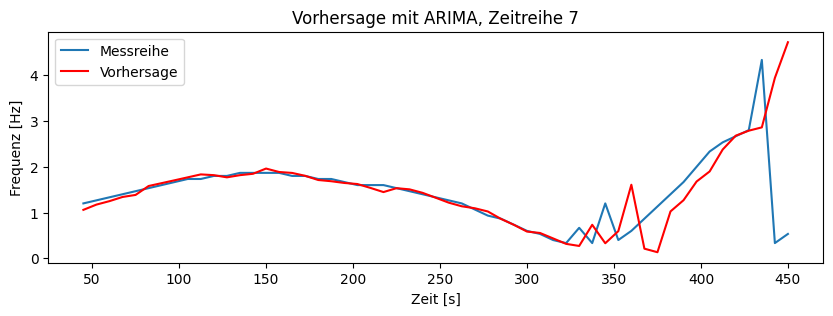

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   60
Model:               SARIMAX(2, 0, 2)   Log Likelihood                 -33.865
Date:                Fri, 10 Nov 2023   AIC                             79.729
Time:                        08:52:03   BIC                             92.295
Sample:                             0   HQIC                            84.645
                                 - 60                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3224      0.185      1.743      0.081      -0.040       0.685
ar.L1          0.2368      0.163      1.455      0.146      -0.082       0.556
ar.L2          0.5295      0.229      2.309      0.0

In [ ]:
# Aufteilen in Trainings- und Testdatensatz
zeitreihe = 6 #hier betrachtete Zeitreihe eintragen, bei 0 anfangend
X = dominant_freqs_all[zeitreihe]
size = int(len(X) * 0.1)
train, test = X[:size], X[size:]

history = list(train)
predictions = []

# Walk-forward validation
for t in range(len(test)):
    # Auto-Arima für die automatische Bestimmung der Parameter nutzen
    model = pm.auto_arima(history, seasonal=False, m=1)
    model_fit = model.fit(history)
    forecast, conf_int = model_fit.predict(n_periods=10, return_conf_int=True)

    yhat = forecast[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

    print(f'Predicted={yhat}, Expected={obs}')

# Plotten der Vorhersage gegen die Messreihe
plt.figure(figsize=(10, 3))
plt.xlabel('Zeit [s]')
plt.ylabel('Frequenz [Hz]')
plt.title(f'Vorhersage mit ARIMA, Zeitreihe {zeitreihe+1}')
plt.plot(t_all[zeitreihe][size:],test, label='Messreihe')
plt.plot(t_all[zeitreihe][size:],predictions, color='red', label='Vorhersage')
plt.legend()
plt.show()
print(model.summary())

In [ ]:
rmse = sqrt(mean_squared_error(test[:42], predictions[:42]))
print(f'Test RMSE: {rmse:.3f}')

Test RMSE: 0.172


Predicted=0.0, Expected=0.9333333333333333
Predicted=0.5333333333333267, Expected=1.0
Predicted=0.6499999999988789, Expected=1.1333333333333333
Predicted=0.7466666665439305, Expected=1.1333333333333333
Predicted=0.8507835191844237, Expected=1.1333333333333333
Predicted=1.049937896564821, Expected=1.2
Predicted=1.125796613386158, Expected=1.2
Predicted=1.1384832280925408, Expected=1.1333333333333333
Predicted=1.0848816786019513, Expected=1.0666666666666667
Predicted=1.0291403047949352, Expected=0.9333333333333333
Predicted=0.9130859689900116, Expected=0.4666666666666667
Predicted=0.5178074894025382, Expected=0.6666666666666666
Predicted=0.6923027076065164, Expected=0.4666666666666667
Predicted=0.5181242418327083, Expected=1.6666666666666667
Predicted=0.9249999998404659, Expected=1.9333333333333333
Predicted=1.5164427823921416, Expected=4.8
Predicted=4.599604772033144, Expected=0.3333333333333333
Predicted=1.15087719192588, Expected=0.4
Predicted=1.1133333332956967, Expected=0.3333333333

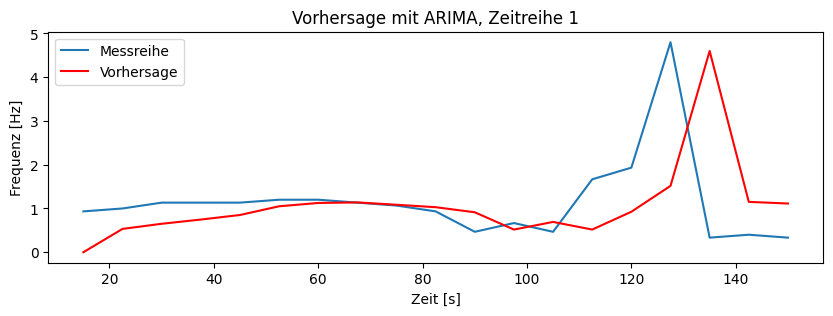

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   20
Model:                        SARIMAX   Log Likelihood                 -27.345
Date:                Fri, 10 Nov 2023   AIC                             58.691
Time:                        09:00:32   BIC                             60.682
Sample:                             0   HQIC                            59.080
                                 - 20                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1133      0.434      2.566      0.010       0.263       1.964
sigma2         0.9018      0.254      3.545      0.000       0.403       1.400
Ljung-Box (L1) (Q):                   0.37   Jarque-

In [ ]:
# Split the data into train and test sets
X = dominant_freqs_all[0]
size = int(len(X) * 0.1)
train, test = X[:size], X[size:]

history = list(train)
predictions = []

# Walk-forward validation
for t in range(len(test)):
    # Use auto_arima to automatically determine the ARIMA model order
    model = pm.auto_arima(history, seasonal=False, m=1)
    model_fit = model.fit(history)
    forecast, conf_int = model_fit.predict(n_periods=1, return_conf_int=True)

    yhat = forecast[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

    print(f'Predicted={yhat}, Expected={obs}')

# Plot forecasts against actual outcomes
# Plotten der Vorhersage gegen die Messreihe
plt.figure(figsize=(10, 3))
plt.xlabel('Zeit [s]')
plt.ylabel('Frequenz [Hz]')
plt.title('Vorhersage mit ARIMA, Zeitreihe 1')
plt.plot(t_all[0][size:],test, label='Messreihe')
plt.plot(t_all[0][size:],predictions, color='red', label='Vorhersage')
plt.legend()
plt.show()
print(model.summary())

In [ ]:
rmse = sqrt(mean_squared_error(test[:13], predictions[:13]))
print(f'Test RMSE: {rmse:.3f}')

Test RMSE: 0.378


Predicted=0.8666666658127474, Expected=1.3333333333333333
Predicted=0.9833333326038877, Expected=1.4
Predicted=1.0666666666625961, Expected=1.4666666666666666
Predicted=1.1333333332285422, Expected=1.5333333333333332
Predicted=1.4760579176268664, Expected=1.4666666666666666
Predicted=1.294259257763908, Expected=1.4
Predicted=1.248707650783679, Expected=1.4
Predicted=1.320022103544321, Expected=1.3333333333333333
Predicted=1.2053750325319763, Expected=1.2666666666666666
Predicted=1.1473844349743627, Expected=1.1333333333333333
Predicted=0.9644374300957439, Expected=1.0
Predicted=0.83948159413012, Expected=0.8666666666666667
Predicted=0.6517699329650954, Expected=0.8
Predicted=0.7086336360321276, Expected=0.6666666666666666
Predicted=0.524025763581218, Expected=0.5333333333333333
Predicted=0.3962898902263935, Expected=0.3333333333333333
Predicted=0.11824210108018196, Expected=0.7333333333333333
Predicted=0.8784154945934548, Expected=0.4666666666666667
Predicted=0.44938161296988816, Expec

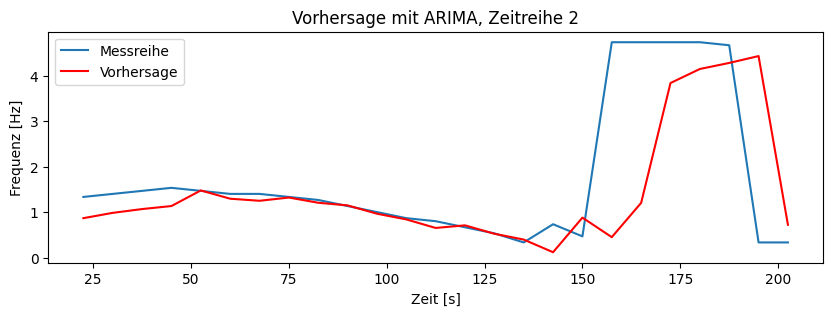

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   27
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -41.180
Date:                Fri, 10 Nov 2023   AIC                             88.361
Time:                        08:53:05   BIC                             92.248
Sample:                             0   HQIC                            89.517
                                 - 27                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4973      0.705      0.706      0.480      -0.884       1.879
ar.L1          0.6713      0.233      2.876      0.004       0.214       1.129
sigma2         1.2096      0.388      3.114      0.0

In [ ]:
# Split the data into train and test sets
X = dominant_freqs_all[1]
size = int(len(X) * 0.11)
train, test = X[:size], X[size:]

history = list(train)
predictions = []

# Walk-forward validation
for t in range(len(test)):
    # Use auto_arima to automatically determine the ARIMA model order
    model = pm.auto_arima(history, seasonal=False, m=1)
    model_fit = model.fit(history)
    forecast, conf_int = model_fit.predict(n_periods=1, return_conf_int=True)

    yhat = forecast[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

    print(f'Predicted={yhat}, Expected={obs}')

# Plotten der Vorhersage gegen die Messreihe
plt.figure(figsize=(10, 3))
plt.xlabel('Zeit [s]')
plt.ylabel('Frequenz [Hz]')
plt.title('Vorhersage mit ARIMA, Zeitreihe 2')
plt.plot(t_all[1][size:],test, label='Messreihe')
plt.plot(t_all[1][size:],predictions, color='red', label='Vorhersage')
plt.legend()
plt.show()
print(model.summary())

In [ ]:
rmse = sqrt(mean_squared_error(test[:17], predictions[:17]))
print(f'Test RMSE: {rmse:.3f}')

Test RMSE: 0.261


Predicted=0.284779371344535, Expected=0.4666666666666667
Predicted=0.380950660048159, Expected=0.6666666666666666
Predicted=0.46666666666021367, Expected=0.8
Predicted=0.5222222222222022, Expected=0.9333333333333333
Predicted=0.8448128776067483, Expected=1.0
Predicted=0.9413163377487979, Expected=1.0666666666666667
Predicted=1.0225595887230183, Expected=1.0666666666666667
Predicted=1.0309763550285997, Expected=1.1333333333333333
Predicted=1.1180531720827167, Expected=1.1333333333333333
Predicted=1.206060606060606, Expected=1.2
Predicted=1.2722218237272138, Expected=1.2666666666666666
Predicted=1.338461135606035, Expected=1.3333333333333333
Predicted=1.404761788500603, Expected=1.3333333333333333
Predicted=1.3999996168305957, Expected=1.3333333333333333
Predicted=1.3958329028378573, Expected=1.3333333333333333
Predicted=1.392156862745098, Expected=1.3333333333333333
Predicted=1.3888887864223671, Expected=1.2666666666666666
Predicted=1.3157890742931602, Expected=1.2
Predicted=1.243332979

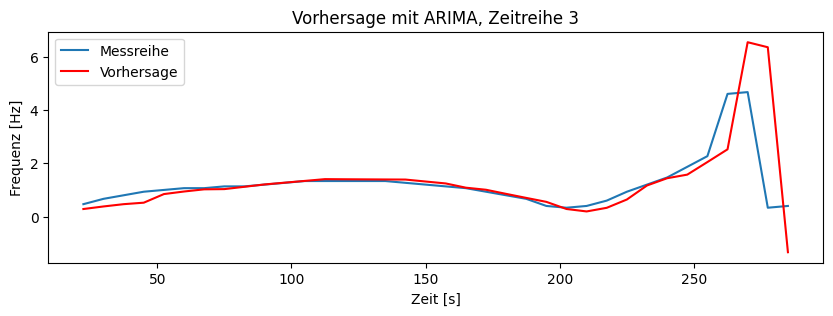

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   38
Model:               SARIMAX(4, 0, 2)   Log Likelihood                 -27.226
Date:                Fri, 10 Nov 2023   AIC                             70.452
Time:                        08:54:35   BIC                             83.552
Sample:                             0   HQIC                            75.113
                                 - 38                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3473      0.594      0.584      0.559      -0.818       1.512
ar.L1          1.5435      1.231      1.254      0.210      -0.869       3.956
ar.L2         -1.2912      2.147     -0.602      0.5

In [ ]:
# Split the data into train and test sets
X = dominant_freqs_all[2]
size = int(len(X) * 0.1)
train, test = X[:size], X[size:]

history = list(train)
predictions = []

# Walk-forward validation
for t in range(len(test)):
    # Use auto_arima to automatically determine the ARIMA model order
    model = pm.auto_arima(history, seasonal=False, m=1)
    model_fit = model.fit(history)
    forecast, conf_int = model_fit.predict(n_periods=1, return_conf_int=True)

    yhat = forecast[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

    print(f'Predicted={yhat}, Expected={obs}')

# Plotten der Vorhersage gegen die Messreihe
plt.figure(figsize=(10, 3))
plt.xlabel('Zeit [s]')
plt.ylabel('Frequenz [Hz]')
plt.title('Vorhersage mit ARIMA, Zeitreihe 3')
plt.plot(t_all[2][size:],test, label='Messreihe')
plt.plot(t_all[2][size:],predictions, color='red', label='Vorhersage')
plt.legend()
plt.show()
print(model.summary())

In [ ]:
rmse = sqrt(mean_squared_error(test[:25], predictions[:25]))
print(f'Test RMSE: {rmse:.3f}')

Test RMSE: 0.137


Predicted=0.5333333331988632, Expected=0.9333333333333333
Predicted=0.8467911621080351, Expected=1.0666666666666667
Predicted=1.0380577092476941, Expected=1.1333333333333333
Predicted=1.1102886560363945, Expected=1.2
Predicted=1.1394533313631867, Expected=1.2666666666666666
Predicted=1.2458367911239643, Expected=1.4
Predicted=1.426287708131759, Expected=1.4
Predicted=1.5066662240963788, Expected=1.4666666666666666
Predicted=1.569696583088286, Expected=1.5333333333333332
Predicted=1.6333329224694304, Expected=1.6
Predicted=1.6974358974358976, Expected=1.6
Predicted=1.6904761747742365, Expected=1.6
Predicted=1.6844444419232427, Expected=1.5333333333333332
Predicted=1.5452642729406134, Expected=1.4666666666666666
Predicted=1.4735504889853053, Expected=1.4
Predicted=1.3336025497497415, Expected=1.4
Predicted=1.318271714990529, Expected=1.3333333333333333
Predicted=1.2404585629659046, Expected=1.2
Predicted=1.128903425255314, Expected=1.1333333333333333
Predicted=1.018332538094354, Expected

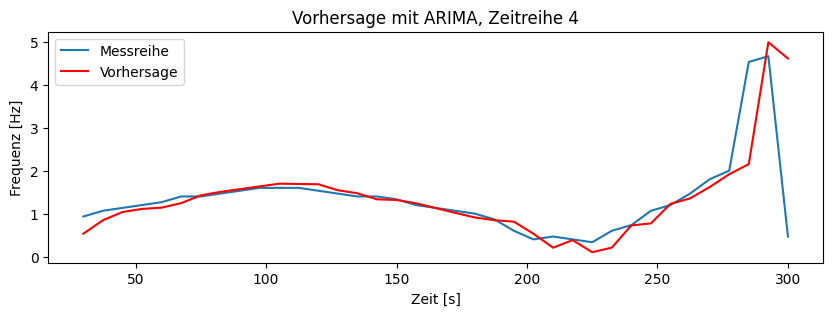

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   40
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -25.042
Date:                Fri, 10 Nov 2023   AIC                             54.085
Time:                        08:56:34   BIC                             57.462
Sample:                             0   HQIC                            55.306
                                 - 40                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9886      0.023     42.825      0.000       0.943       1.034
sigma2         0.1863      0.013     14.496      0.000       0.161       0.211
Ljung-Box (L1) (Q):                   0.96   Jarque-

In [ ]:
# Split the data into train and test sets
X = dominant_freqs_all[3]
size = int(len(X) * 0.11)
train, test = X[:size], X[size:]

history = list(train)
predictions = []

# Walk-forward validation
for t in range(len(test)):
    # Use auto_arima to automatically determine the ARIMA model order
    model = pm.auto_arima(history, seasonal=False, m=1)
    model_fit = model.fit(history)
    forecast, conf_int = model_fit.predict(n_periods=1, return_conf_int=True)

    yhat = forecast[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

    print(f'Predicted={yhat}, Expected={obs}')

# Plotten der Vorhersage gegen die Messreihe
plt.figure(figsize=(10, 3))
plt.xlabel('Zeit [s]')
plt.ylabel('Frequenz [Hz]')
plt.title('Vorhersage mit ARIMA, Zeitreihe 4')
plt.plot(t_all[3][size:],test, label='Messreihe')
plt.plot(t_all[3][size:],predictions, color='red', label='Vorhersage')
plt.legend()
plt.show()
print(model.summary())

In [ ]:
rmse = sqrt(mean_squared_error(test[:27], predictions[:27]))
print(f'Test RMSE: {rmse:.3f}')

Test RMSE: 0.139


Predicted=1.022222222072251, Expected=1.4
Predicted=1.1166666666666667, Expected=1.5333333333333332
Predicted=1.1999999999964146, Expected=1.6
Predicted=1.2666666654680245, Expected=1.6666666666666667
Predicted=1.3238095237931697, Expected=1.6666666666666667
Predicted=1.3666666664162983, Expected=1.7333333333333334
Predicted=1.4074074070915232, Expected=1.8
Predicted=1.446666666405551, Expected=1.8
Predicted=1.9466645114943872, Expected=1.7333333333333334
Predicted=1.7333333333333334, Expected=1.7333333333333334
Predicted=1.7333333333333334, Expected=1.7333333333333334
Predicted=1.7333333333333334, Expected=1.7333333333333334
Predicted=1.7333333333333334, Expected=1.7333333333333334
Predicted=1.7333333333333334, Expected=1.6666666666666667
Predicted=1.6666666666666667, Expected=1.6
Predicted=1.4564136230456353, Expected=1.4666666666666666
Predicted=1.4437162011363256, Expected=1.3333333333333333
Predicted=1.3259455404663671, Expected=1.2
Predicted=1.2058397864336112, Expected=1.1333333

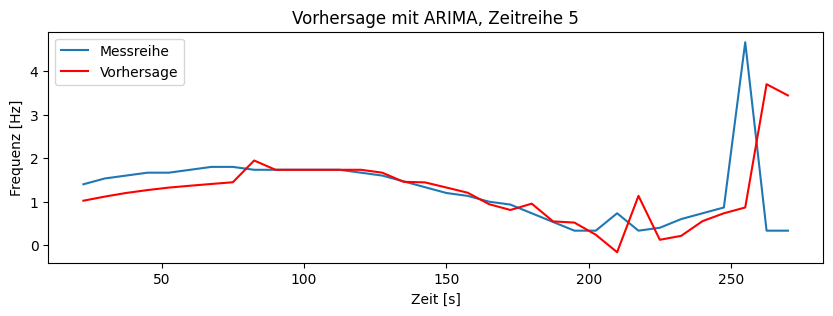

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   36
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 -38.543
Date:                Fri, 10 Nov 2023   AIC                             85.085
Time:                        08:57:36   BIC                             91.419
Sample:                             0   HQIC                            87.296
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5580      0.592      0.942      0.346      -0.603       1.719
ar.L1         -0.0385      0.220     -0.175      0.861      -0.470       0.392
ar.L2          0.6211      0.501      1.239      0.2

In [ ]:
# Split the data into train and test sets
X = dominant_freqs_all[4]
size = int(len(X) * 0.1)
train, test = X[:size], X[size:]

history = list(train)
predictions = []

# Walk-forward validation
for t in range(len(test)):
    # Use auto_arima to automatically determine the ARIMA model order
    model = pm.auto_arima(history, seasonal=False, m=1)
    model_fit = model.fit(history)
    forecast, conf_int = model_fit.predict(n_periods=1, return_conf_int=True)

    yhat = forecast[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

    print(f'Predicted={yhat}, Expected={obs}')

# Plotten der Vorhersage gegen die Messreihe
plt.figure(figsize=(10, 3))
plt.xlabel('Zeit [s]')
plt.ylabel('Frequenz [Hz]')
plt.title('Vorhersage mit ARIMA, Zeitreihe 5')
plt.plot(t_all[4][size:],test, label='Messreihe')
plt.plot(t_all[4][size:],predictions, color='red', label='Vorhersage')
plt.legend()
plt.show()
print(model.summary())

In [ ]:
rmse = sqrt(mean_squared_error(test[:28], predictions[:28]))
print(f'Test RMSE: {rmse:.3f}')

Test RMSE: 0.321


Predicted=0.4399999998949995, Expected=0.8
Predicted=0.8210652280046847, Expected=0.8666666666666667
Predicted=0.8554287406578343, Expected=0.9333333333333333
Predicted=0.9022807000127471, Expected=1.0666666666666667
Predicted=1.1304571591213337, Expected=1.0666666666666667
Predicted=1.0260274071889854, Expected=1.1333333333333333
Predicted=1.1283035351602546, Expected=1.2
Predicted=1.2787878787878788, Expected=1.2666666666666666
Predicted=1.3444444444444443, Expected=1.3333333333333333
Predicted=1.4102559996133825, Expected=1.3333333333333333
Predicted=1.4047614680812455, Expected=1.4
Predicted=1.4711111067892357, Expected=1.4666666666666666
Predicted=1.5374999999999999, Expected=1.5333333333333332
Predicted=1.6039212725626595, Expected=1.5333333333333332
Predicted=1.5999999999999999, Expected=1.5333333333333332
Predicted=1.5964908010106202, Expected=1.5333333333333332
Predicted=1.5933332484069338, Expected=1.5333333333333332
Predicted=1.590476129468446, Expected=1.5333333333333332
Pr

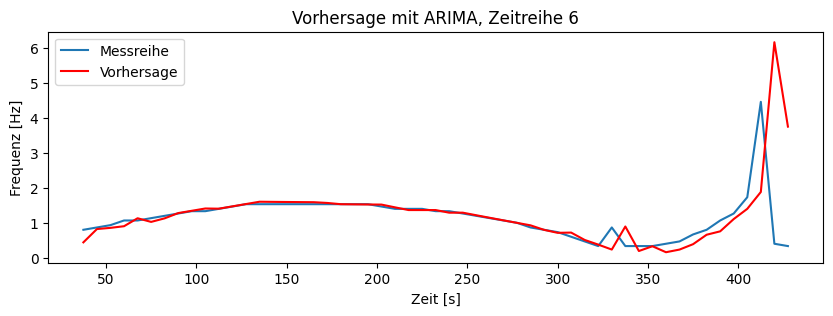

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   57
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 -42.701
Date:                Fri, 10 Nov 2023   AIC                             93.402
Time:                        09:00:06   BIC                            101.574
Sample:                             0   HQIC                            96.578
                                 - 57                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2239      0.490      0.457      0.648      -0.736       1.184
ar.L1          0.0171      0.112      0.152      0.879      -0.203       0.237
ar.L2          0.7892      0.516      1.530      0.1

In [ ]:
# Split the data into train and test sets
X = dominant_freqs_all[5]
size = int(len(X) * 0.1)
train, test = X[:size], X[size:]

history = list(train)
predictions = []

# Walk-forward validation
for t in range(len(test)):
    # Use auto_arima to automatically determine the ARIMA model order
    model = pm.auto_arima(history, seasonal=False, m=1)
    model_fit = model.fit(history)
    forecast, conf_int = model_fit.predict(n_periods=1, return_conf_int=True)

    yhat = forecast[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

    print(f'Predicted={yhat}, Expected={obs}')

# Plotten der Vorhersage gegen die Messreihe
plt.figure(figsize=(10, 3))
plt.xlabel('Zeit [s]')
plt.ylabel('Frequenz [Hz]')
plt.title('Vorhersage mit ARIMA, Zeitreihe 6')
plt.plot(t_all[5][size:],test, label='Messreihe')
plt.plot(t_all[5][size:],predictions, color='red', label='Vorhersage')
plt.legend()
plt.show()
print(model.summary())

In [ ]:
rmse = sqrt(mean_squared_error(test[:27], predictions[:27]))
print(f'Test RMSE: {rmse:.3f}')

Test RMSE: 0.091
